In [323]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math

In [324]:
Target_cell_number = 2e5
well_size = 150e-6
E_T_ratio = 1
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
r_ab = 1.25e-8
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
reaction_volume1 = (2*1e3*math.pi*(r_ab**3))/3 # in L
reaction_volume2 = (2*1e3/3)*math.pi*((0.5*r_ab)**3) # in L
reaction_volume3 = (2*1e3/3)*math.pi*((2*r_ab)**3) # in L
reaction_volume_4 = (1e3/3)*math.pi*((r_ab)**3) # in L
print(tumour_cell_IS_proportion, NK_cell_IS_proportion)
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

0.12433979929054326 0.7533961803166646


In [325]:
print(sigma_synapse)

7.527675950000002


In [326]:
def R_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def S_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

In [327]:
def R_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot, rtot_fc, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt/rtot) + 2*k1off*z[1] - k4*z[0]*(rf/rtot_fc) + k2off*z[3]
    dA20 = k2*z[0]*(rt/rtot) - 2*k1off*z[1] - k5*z[1]*(rf/rtot_fc) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k6*z[2]*(rt/rtot) + k1off*z[3]
    dA11 = k4*z[0]*(rf/rtot_fc) - k2off*z[3] + 2*k6*z[2]*(rt/rtot) -k1off*z[3] - k7*z[3]*(rt/rtot) + 2*k1off*z[4]
    dA21 = k5*z[1]*(rf/rtot_fc) - k2off*z[4] + k7*z[3]*(rt/rtot) - 2*k2off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt) + 2*k1off*z[1] - k4*z[0]*(rf) + k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*k1off*z[1] - k5*z[1]*(rf) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k6*z[2]*(rt) + k1off*z[3]
    dA11 = k4*z[0]*(rf) - k2off*z[3] + 2*k6*z[2]*(rt) -k1off*z[3] - k7*z[3]*(rt) + 2*k1off*z[4]
    dA21 = k5*z[1]*(rf) - k2off*z[4] + k7*z[3]*(rt) - 2*k2off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [328]:
def NK_cell_model(t, z, qon, qoff, rtot, Atot, E_T_ratio):
    
    qon = qon*E_T_ratio/sigma
    r = rtot - z
    A0 = Atot - z
    dA1 = qon*r*A0 - qoff*z

    return dA1

In [329]:
kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e5
rtot_fc = 2.2e5
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion

k1 = kon/sigma_synapse
k3 = qon/sigma_synapse

target_effective_conc1 =(rtot_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
k2 = target_effective_conc1*kon

target_effective_conc2 = (rtot_fc_synapse)*((math.pi*((2*r_ab)**2))/(synapse_width**2))*(1/N_A)/(reaction_volume3)
k4 = target_effective_conc2*qon

target_effective_conc3 = (rtot_fc_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
k5 = target_effective_conc3*qon

target_effective_conc4 = (rtot_synapse)*((math.pi*((r_ab)**2))/(synapse_width**2))*(1/N_A)/(reaction_volume3)
k6 = target_effective_conc2*kon

target_effective_conc5 = (rtot_synapse)*((math.pi*(r_ab**2)/2)/(synapse_width**2))*(1/N_A)/(reaction_volume_4)
k7 = target_effective_conc5*kon

In [330]:
target_effective_conc1 =(rtot_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
k2 = target_effective_conc1*kon


In [375]:
Ainit = 1e-7
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 500)
tspan = [1e-10, t_end]
target_effective_conc =(rtot)*((math.pi*(r_ab**2))/(tumour_cell_surface_area))*(1/N_A)/(reaction_volume1)
k2_single = target_effective_conc*kon
"""
D_t = 1e-14
D_f = 7.4e-14
kon=1e5
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
k2 = 4*D_t/(tumour_cell_surface_area)
k4 = 4*D_f/(NK_cell_surface_area)   
"""
z0 = [0, 0]
synapse_area = synapse_width**2
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse  
D_t = 1e-14
D_f = 7.4e-14
kon = 1e5
koff = 1e-4
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
k2 = 4*D_t/(synapse_area)
k2_single = 4*D_t/(tumour_cell_surface_area)
k4 = 2*(D_t +D_f)/(synapse_area)   
k5 = 2*(D_t +D_f)/(synapse_area)  
k6 = 2*(D_t +D_f)/(synapse_area)  
k7 = 2*D_t/synapse_area

z = solve_ivp(S_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

Atot_whole = well_size*N_A*Ainit/Target_cell_number
A1 = z.y[0]
A2 = z.y[1]

Atot_NK = Atot_whole - A1[-1] - A2[-1]

z = solve_ivp(NK_cell_model, tspan, [0], method='Radau', t_eval=t, args=(qon, qoff, rtot_fc, Atot_NK, E_T_ratio))

A01 = z.y[0]
print(A01[-1]*NK_cell_IS_proportion/rtot_fc_synapse)
A01_IC = A01[-1]*NK_cell_IS_proportion

A10_IC = A1[-1]*tumour_cell_IS_proportion
A20_IC = A2[-1]*tumour_cell_IS_proportion

Atot = A10_IC + A20_IC + A01_IC
z0 = [A10_IC, A20_IC, A01_IC, 0, 0]
    
z = solve_ivp(S_two_cells, tspan, z0, method='BDF', rtol = 1e-5, t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
print(z.message)
A10 = z.y[0]
A20 = z.y[1]
A01 = z.y[2]
A11 = z.y[3]
A21 = z.y[4]


0.1751451561096851
The solver successfully reached the end of the integration interval.


12429.34679656467


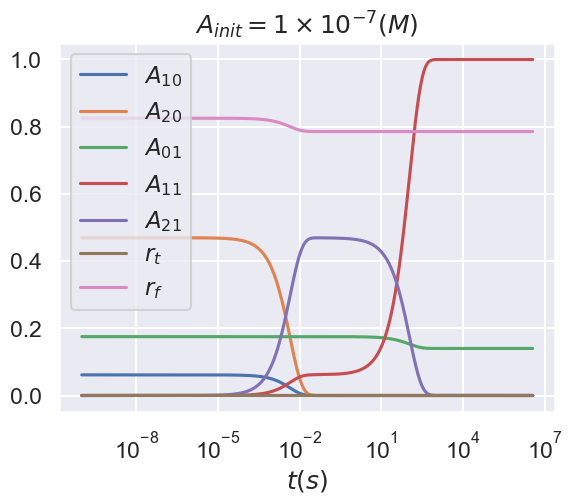

In [377]:
rt = rtot_synapse- A10 - A11 - 2*(A20 + A21)
rf = rtot_fc_synapse - A01 - (A11 + A21)


plt.plot(t, A10/rtot_synapse, label = r'$A_{10}$')
plt.plot(t, A20/rtot_synapse, label = r'$A_{20}$')
plt.plot(t, A01/rtot_fc_synapse, label = r'$A_{01}$')
plt.plot(t, A11/rtot_synapse, label = r'$A_{11}$')
plt.plot(t, A21/rtot_synapse, label = r'$A_{21}$')
plt.plot(t, rt/rtot_synapse, label = r'$r_t$')
plt.plot(t, rf/rtot_fc_synapse, label = r'$r_f$')
print(A11[-1] + A21[-1])

plt.title(r'$A_{init} = 1 \times 10^{-7} (M)$')
plt.xscale('log')
plt.xlabel(r'$t (s)$')
plt.legend(loc='upper left')
plt.show()

In [333]:
rtot = 1e4
kon = 1e6
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
target_effective_conc5 = (rtot_synapse)*((math.pi*(r_ab**2)/2)/(synapse_width**2))*(1/N_A)/(reaction_volume_4)
k7 = target_effective_conc5*kon/rtot_synapse
print(6.5e3/sigma_synapse)


863.4803149304


In [334]:
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 500)
tspan = [1e-10, t_end]
A0s = np.geomspace(1e-12, 1e-4, 75)
rtots = [1e4, 1e5, 1e6]
qons = [1e3, 5e3, 1e4]
A10rs = np.zeros((len(rtots), len(A0s)))
A20rs = np.zeros((len(rtots), len(A0s)))
A01rs = np.zeros((len(rtots), len(A0s)))
A11rs = np.zeros((len(rtots), len(A0s)))
A21rs = np.zeros((len(rtots), len(A0s)))
rtot = 1e5
for j, qon in enumerate(qons):
    """
    D_t = 1e-14
    D_f = 7.4e-14
    kon=1e5
    rtot_synapse = rtot*tumour_cell_IS_proportion
    rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(tumour_cell_surface_area)
    k4 = 4*D_f/(NK_cell_surface_area)   
    """

    target_effective_conc =(rtot)*((math.pi*(r_ab**2))/(tumour_cell_surface_area))*(1/N_A)/(reaction_volume1)
    k2_single = target_effective_conc*kon   
    rtot_synapse = rtot*tumour_cell_IS_proportion

    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse

    target_effective_conc1 =(rtot_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
    k2 = target_effective_conc1*kon

    target_effective_conc2 = (rtot_fc_synapse)*((math.pi*((2*r_ab)**2))/(synapse_width**2))*(1/N_A)/(reaction_volume3)
    k4 = target_effective_conc2*qon

    target_effective_conc3 = (rtot_fc_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
    k5 = target_effective_conc3*qon

    target_effective_conc4 = (rtot_synapse)*((math.pi*((r_ab)**2))/(synapse_width**2))*(1/N_A)/(reaction_volume3)
    k6 = target_effective_conc2*kon

    target_effective_conc5 = (rtot_synapse)*((math.pi*(r_ab**2)/2)/(synapse_width**2))*(1/N_A)/(reaction_volume_4)
    k7 = target_effective_conc5*kon
    for i, Ainit in enumerate(A0s):
        print(i)
        z0 = [0, 0]
        z = solve_ivp(R_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

        Atot_whole = well_size*N_A*Ainit/Target_cell_number
        A1 = z.y[0]
        A2 = z.y[1]

        Atot_NK = (Atot_whole - A1[-1] - A2[-1])/E_T_ratio

        z = solve_ivp(NK_cell_model, tspan, [0], method='BDF', t_eval=t, args=(qon, qoff, rtot_fc, Atot_NK, E_T_ratio))

        A01 = z.y[0]

        A01_IC = A01[-1]*NK_cell_IS_proportion
        A10_IC = A1[-1]*tumour_cell_IS_proportion
        A20_IC = A2[-1]*tumour_cell_IS_proportion

        #Atot = A10_IC + A20_IC + A01_IC
        Atot = A10_IC + A20_IC 
        z0 = [A10_IC, A20_IC, 0, 0, 0]
    
        z = solve_ivp(R_two_cells, tspan, z0, method='BDF', atol = 1e-5, rtol = 1e-5, t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
        print(z.message)
        A10 = z.y[0]
        A20 = z.y[1]
        A01 = z.y[2]
        A11 = z.y[3]
        A21 = z.y[4]

        A10rs[j][i] = A10[-1]
        A20rs[j][i] = A20[-1]
        A01rs[j][i] = A01[-1]
        A11rs[j][i] = A11[-1]
        A21rs[j][i] = A21[-1]

0
The solver successfully reached the end of the integration interval.
1
The solver successfully reached the end of the integration interval.
2
The solver successfully reached the end of the integration interval.
3
The solver successfully reached the end of the integration interval.
4
The solver successfully reached the end of the integration interval.
5
The solver successfully reached the end of the integration interval.
6
The solver successfully reached the end of the integration interval.
7
The solver successfully reached the end of the integration interval.
8
Required step size is less than spacing between numbers.
9
The solver successfully reached the end of the integration interval.
10
The solver successfully reached the end of the integration interval.
11
The solver successfully reached the end of the integration interval.
12
The solver successfully reached the end of the integration interval.
13
The solver successfully reached the end of the integration interval.
14
The solver 

In [335]:
sns.set_theme()
sns.set_context('talk')
"""
plt.plot(A0s, A10rs/rtot_synapse, label = r'$A_{10}$')
plt.plot(A0s, A20rs/rtot_synapse, label = r'$A_{20}$')
plt.plot(A0s, A01rs/rtot_fc_synapse, label = r'$A_{01}$')
plt.plot(A0s, A11rs/rtot_synapse, label = r'$A_{11}$')
plt.plot(A0s, A21rs/rtot_synapse, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()
"""

"\nplt.plot(A0s, A10rs/rtot_synapse, label = r'$A_{10}$')\nplt.plot(A0s, A20rs/rtot_synapse, label = r'$A_{20}$')\nplt.plot(A0s, A01rs/rtot_fc_synapse, label = r'$A_{01}$')\nplt.plot(A0s, A11rs/rtot_synapse, label = r'$A_{11}$')\nplt.plot(A0s, A21rs/rtot_synapse, label = r'$A_{21}$')\n\n\nplt.xscale('log')\nplt.legend(loc='best')\nplt.show()\n"

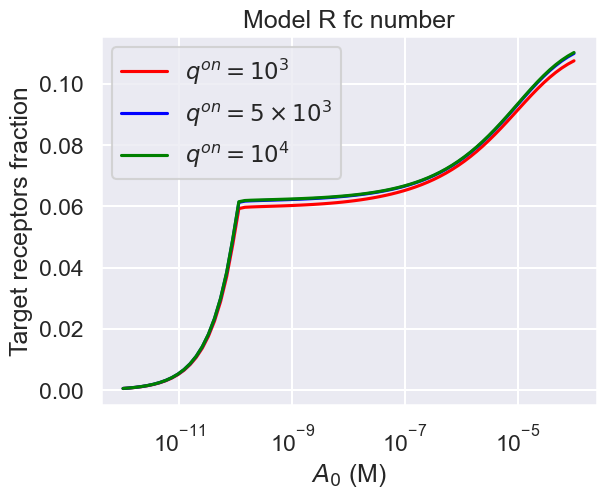

In [336]:
labels = [r'$q^{on} = 10^3$', r'$q^{on} = 5 \times 10^3$', r'$q^{on} = 10^4$']
colors = ['red', 'blue', 'green']

for i, label in enumerate(labels):
    plt.plot(A0s, (A11rs[i][:] + A21rs[i][:])/rtot, label=label, c=colors[i])

plt.xscale('log')
plt.title('Model R fc number')
plt.legend(loc='best')
plt.xlabel(r'$A_0$ ' + '(M)')
plt.ylabel('Target receptors fraction')
plt.show()

In [337]:
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 1000)
tspan = [1e-10, t_end]
A0s = np.geomspace(1e-12, 1e-4, 75)
rtots = [1e4, 1e5, 1e6]

A10ss = np.zeros((len(rtots), len(A0s)))
A20ss = np.zeros((len(rtots), len(A0s)))
A01ss = np.zeros((len(rtots), len(A0s)))
A11ss = np.zeros((len(rtots), len(A0s)))
A21ss = np.zeros((len(rtots), len(A0s)))
kon = 1e5
koff = 1e-4
qoff = 4.7e-3
rtot_fc = 2.2e5
rtot = 1e5
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
synapse_area = synapse_width**2
for j, qon in enumerate(qons):
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse  
    D_t = 1e-14
    D_f = 7.4e-14
    kon = 1e5
    koff = 1e-4
    rtot_synapse = rtot*tumour_cell_IS_proportion
    rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    k2_single = 4*D_t/(tumour_cell_surface_area)
    k4 = 2*(D_t +D_f)/(synapse_area)   
    k5 = 2*(D_t +D_f)/(synapse_area)  
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area
    
    for i, Ainit in enumerate(A0s):
        print(i)
        z0 = [0, 0]
        z = solve_ivp(S_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

        Atot_whole = well_size*N_A*Ainit/Target_cell_number
        A1 = z.y[0]
        A2 = z.y[1]

        Atot_NK = (Atot_whole - A1[-1] - A2[-1])/E_T_ratio

        z = solve_ivp(NK_cell_model, tspan, [0], method='BDF', t_eval=t, args=(qon, qoff, rtot_fc, Atot_NK, E_T_ratio))

        A01 = z.y[0]

        A01_IC = A01[-1]*NK_cell_IS_proportion
        A10_IC = A1[-1]*tumour_cell_IS_proportion
        A20_IC = A2[-1]*tumour_cell_IS_proportion

        #Atot = A10_IC + A20_IC + A01_IC
        Atot = A10_IC + A20_IC 
        z0 = [A10_IC, A20_IC, 0, 0, 0]
    
        z = solve_ivp(S_two_cells, tspan, z0, method='BDF', atol=1e-5, rtol = 1e-5,  t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
        print(z.message)
        A10 = z.y[0]
        A20 = z.y[1]
        A01 = z.y[2]
        A11 = z.y[3]
        A21 = z.y[4]

        A10ss[j][i] = A10[-1]
        A20ss[j][i] = A20[-1]
        A01ss[j][i] = A01[-1]
        A11ss[j][i] = A11[-1]
        A21ss[j][i] = A21[-1]

0
The solver successfully reached the end of the integration interval.
1
The solver successfully reached the end of the integration interval.
2
The solver successfully reached the end of the integration interval.
3
The solver successfully reached the end of the integration interval.
4
The solver successfully reached the end of the integration interval.
5
The solver successfully reached the end of the integration interval.
6
The solver successfully reached the end of the integration interval.
7
The solver successfully reached the end of the integration interval.
8
The solver successfully reached the end of the integration interval.
9
The solver successfully reached the end of the integration interval.
10
The solver successfully reached the end of the integration interval.
11
The solver successfully reached the end of the integration interval.
12
The solver successfully reached the end of the integration interval.
13
The solver successfully reached the end of the integration interval.
14

In [338]:
D_t = 1e-13
k6 = 2*(D_t +D_f)/(synapse_area)  
k7 = 2*D_t/synapse_area
print(k6, k7)

0.0034799999999999996 0.0019999999999999996


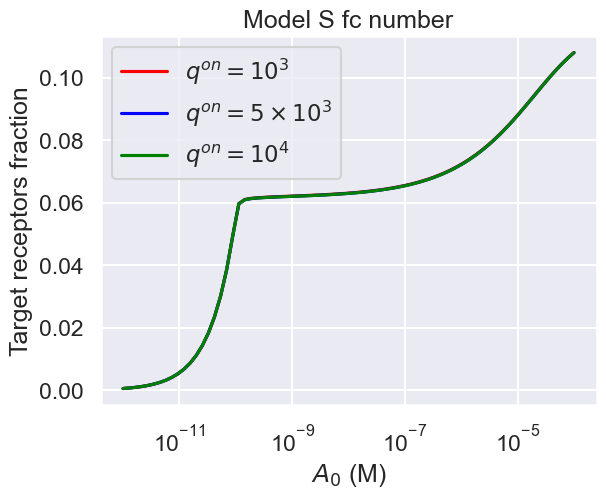

In [339]:
labels = [r'$q^{on} = 10^3$', r'$q^{on} = 5 \times 10^3$', r'$q^{on} = 10^4$']
colors = ['red', 'blue', 'green']

for i, label in enumerate(labels):
    plt.plot(A0s, A11ss[i][:]/rtot + A21ss[i][:]/rtot, label=label, c=colors[i])

plt.xscale('log')
plt.title('Model S fc number')
plt.legend(loc='best')
plt.xlabel(r'$A_0$ ' + '(M)')
plt.ylabel('Target receptors fraction')
plt.show()